In [1]:
!pip install deepxde
!pip install numpy
!pip install mathplot
!pip install scipy
!pip install os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io as sio

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



In [3]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

In [4]:
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [5]:
def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.6 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.6 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [6]:
bc_u_0 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0)
bc_u_1 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0)
bc_v_0 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1)
bc_v_1 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1)

def init_cond_u(x):
    return 2 / np.cosh(x[:, 0:1])

def init_cond_v(x):
    return 0

ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [7]:
data = dde.data.TimePDE(geomtime, pde, [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
                        num_domain=10000, num_boundary=20, num_initial=200, train_distribution="pseudo")

In [8]:
net = dde.nn.FNN([2] + [100] * 5 + [2], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [9]:
model.compile("adam", lr=1e-2, loss="MSE")
model.train(iterations=10000, display_every=1000)

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Compiling model...
Building feed-forward neural network...
'build' took 0.121573 s

'compile' took 1.516345 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.31e-03, 3.61e-03, 1.27e-02, 1.17e-04, 3.53e-01, 5.78e-04, 7.47e-01, 6.96e-02]    [3.31e-03, 3.61e-03, 1.27e-02, 1.17e-04, 3.53e-01, 5.78e-04, 7.47e-01, 6.96e-02]    []  
1000      [9.39e-03, 3.11e-02, 6.38e-05, 1.31e-03, 5.67e-05, 2.91e-04, 1.67e-01, 2.89e-03]    [9.39e-03, 3.11e-02, 6.38e-05, 1.31e-03, 5.67e-05, 2.91e-04, 1.67e-01, 2.89e-03]    []  
2000      [1.65e-02, 1.76e-02, 7.42e-05, 5.38e-04, 1.70e-06, 3.79e-04, 6.02e-02, 1.11e-03]    [1.65e-02, 1.76e-02, 7.42e-05, 5.38e-04, 1.70e-06, 3.79e-04, 6.02e-02, 1.11e-03]    []  
3000      [1.34e-02, 1.22e-02, 2.42e-06, 7.67e-04, 4.11e-06, 2.85e-05, 3.52e-02, 1.40e-03]    [1.34e-02, 1.22e-02, 2.42e-06, 7.67e-

(<deepxde.model.LossHistory at 0x7feca7516b90>,
 <deepxde.model.TrainState at 0x7feca7516ec0>)

In [10]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.594410 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [3.98e-03, 3.36e-03, 3.69e-06, 3.09e-05, 1.25e-05, 5.44e-05, 5.29e-03, 1.36e-04]    [3.98e-03, 3.36e-03, 3.69e-06, 3.09e-05, 1.25e-05, 5.44e-05, 5.29e-03, 1.36e-04]    []  
11000     [5.07e-05, 6.29e-05, 3.93e-07, 3.60e-06, 1.06e-06, 4.14e-06, 1.09e-05, 5.14e-06]    [5.07e-05, 6.29e-05, 3.93e-07, 3.60e-06, 1.06e-06, 4.14e-06, 1.09e-05, 5.14e-06]        
12000     [1.40e-05, 1.43e-05, 1.57e-07, 3.02e-06, 1.55e-07, 1.93e-06, 3.77e-06, 1.89e-06]    [1.40e-05, 1.43e-05, 1.57e-07, 3.02e-06, 1.55e-07, 1.93e-06, 3.77e-06, 1.89e-06]        
13000     [7.99e-06, 7.04e-06, 2.24e-07, 1.68e-06, 3.26e-08, 1.95e-06, 3.06e-06, 6.56e-07]    [7.99e-06, 7.04e-06, 2.24e-07, 1.68e-06, 3.26e-08, 1.95e-06, 3.06e-06, 6.56e-07]        
14000     [5.

(<deepxde.model.LossHistory at 0x7feca7516b90>,
 <deepxde.model.TrainState at 0x7feca7516ec0>)

In [11]:
prediction = model.predict(X_star, operator=None)

predicted_u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
predicted_v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
h = np.sqrt(predicted_u ** 2 + predicted_v ** 2)

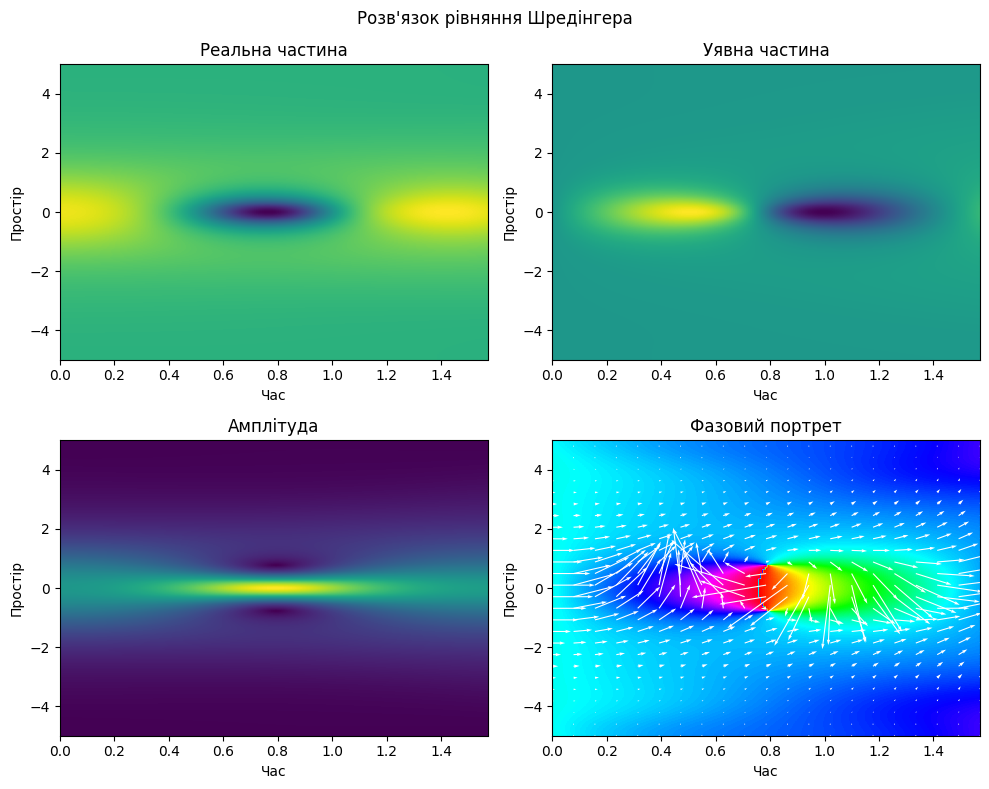

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Розв'язок рівняння Шредінгера")

axs[0, 0].set_title("Реальна частина")
axs[0, 0].imshow(predicted_u.T, cmap="viridis", extent=[t_lower, t_upper, x_lower, x_upper], origin="lower", aspect="auto")
axs[0, 0].set_xlabel("Час")
axs[0, 0].set_ylabel("Простір")

# Imaginary part
axs[0, 1].set_title("Уявна частина")
axs[0, 1].imshow(predicted_v.T, cmap="viridis", extent=[t_lower, t_upper, x_lower, x_upper], origin="lower", aspect="auto")
axs[0, 1].set_xlabel("Час")
axs[0, 1].set_ylabel("Простір")

# Amplitude
axs[1, 0].set_title("Амплітуда")
axs[1, 0].imshow(h.T, cmap="viridis", extent=[t_lower, t_upper, x_lower, x_upper], origin="lower", aspect="auto")
axs[1, 0].set_xlabel("Час")
axs[1, 0].set_ylabel("Простір")

phase = np.arctan2(predicted_v, predicted_u)

# Plot Phase
axs[1, 1].set_title("Фазовий портрет")
axs[1, 1].imshow(phase.T, cmap="hsv", extent=[t_lower, t_upper, x_lower, x_upper], origin="lower", aspect="auto")
axs[1, 1].set_xlabel("Час")
axs[1, 1].set_ylabel("Простір")

# Plot Vector Field (Arrows)
x_arrow = x[::10]
t_arrow = t[::10]
u_arrow = predicted_u[::10, ::10]
v_arrow = predicted_v[::10, ::10]

axs[1, 1].quiver(t_arrow, x_arrow, u_arrow.T, v_arrow.T, color='white', scale=20)

plt.tight_layout()
plt.show()